## 03c - Geocentric Models

#### Imports

In [1]:
# ruff: noqa: F405
from init_notebook import *

%config InlineBackend.figure_formats = ['svg']

Module aliases imported by init_notebook.py:
--------------------------------------------
import numpy as np

import pandas as pd

import statsmodels.formula.api as smf

import pymc as pm

import xarray as xr

import arviz as az

import utils as utils

import seaborn as sns

from scipy import stats as stats

from matplotlib import pyplot as plt

Watermark:
----------
Last updated: 2025-02-13T11:56:05.206598+04:00

Python implementation: CPython
Python version       : 3.12.8
IPython version      : 8.32.0

Compiler    : MSC v.1942 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 61 Stepping 4, GenuineIntel
CPU cores   : 4
Architecture: 64bit

numpy      : 1.26.4
xarray     : 2025.1.2
pandas     : 2.2.2
matplotlib : 3.10.0
watermark  : 2.5.0
statsmodels: 0.14.4
scipy      : 1.15.1
seaborn    : 0.13.2
arviz      : 0.20.0
pymc       : 5.20.1



In [ ]:
from patsy import dmatrix

def bspline_regression_plots(data, knot_list, degree):
    
    B_mat = np.asarray(dmatrix(
        f"bs(year, knots=knots, degree={degree}, include_intercept=True)-1",
        {"year": data.year.values, "knots": knot_list[1:-1]},
    ))    
    
    with pm.Model() as model:
        B = pm.ConstantData("B", B_mat)
        a = pm.Normal("a", mu=100, sigma=10)
        w = pm.Normal("w", mu=0, sigma=10, shape=B.shape[1])
        sigma = pm.Exponential("sigma", 1)
        mu = pm.Deterministic('mu', a + pm.math.dot(B, w.T))
        D = pm.Normal("D", mu=mu, sigma=sigma, observed=data.doy.values)    
        custom_steps = utils.QuadraticApproximation([a, w, sigma], model)
        trace_quap = pm.sample(draws=1_000, chains=1, tune=0, step=custom_steps, progressbar=False)  
    
    wp = trace_quap.posterior.w.mean(dim=["chain", "draw"]).to_numpy()
    
    _, axs = plt.subplots(3, 1, figsize=(8, 8))
    axs[0].plot(data.year, B_mat)
    axs[0].set(xlabel='Year', ylabel='Basis Value')
    
    axs[1].plot(data.year, B_mat * wp)
    axs[1].set(xlabel='Year', ylabel='Basis * Weight')    
    
    az.plot_hdi(data.year, trace_quap.posterior['mu'], smooth=False, color='k', ax=axs[2])
    axs[2].plot(data.year, data.doy, 'o', color='pink', alpha=0.6)
    axs[2].set(xlabel='Year', ylabel='Day in Year')

#### Practice Problems

##### 4E1
In the model definition below, which line is the likelihood?

$$\begin{align*}
y_{i} &\sim \text{Normal}(\mu, \sigma)\\
\mu &\sim \text{Normal}(0,10)\\
\sigma &\sim \text{Exponential}(1)\\
\end{align*}$$

The first line $y_{i} \sim \text{Normal}(\mu, \sigma)$ is the likelihood. The second line is very similar, but is instead the prior for the parameter $μ$. The third line is the prior for the parameter $σ$. Likelihoods and priors can look very similar, because a likelihood is effectively a prior for the residuals.

##### 4E2
In the model definition just above, how many parameters are in the posterior distribution?

There are two parameters in the posterior distribution $\mu$ and $\sigma$.

##### 4E3
Using the model definition above, write down the appropriate form of Bayes’ theorem that includes the proper likelihood and priors.

Ignoring the specific distributions for the moment:

$$Pr(\mu, \sigma \mid y) = \frac{Pr(y \mid \mu, \sigma) Pr(\mu) Pr(\sigma)}{\int\int Pr(y \mid \mu, \sigma) Pr(\mu) Pr(\sigma) d\mu d\sigma}$$


Now inserting the distributional assumptions:
$$Pr(\mu, \sigma \mid y) = \frac{\sum_i \text{Normal}(y_i \mid \mu, \sigma) \text{Normal}(\mu \mid 0,10) \text{Exponential}(\sigma \mid 1) }{\int\int\sum_i \text{Normal}(y_i \mid \mu, \sigma) \text{Normal}(\mu \mid 0,10) \text{Exponential}(\sigma \mid 1)d\mu d\sigma}$$


$ Pr(\mu,\sigma | \underline{x}) = \frac{Pr(\underline{x}|\mu,\sigma)Pr(\mu)Pr(\sigma)}{Pr(\underline{h})} \propto \frac{1}{\sigma}\prod_i exp(-\frac{1}{2}(\frac{x_i - \mu}{\sigma})^2) \times  exp(-\frac{1}{2}(\frac{\mu}{10})^2) \times exp(-\sigma)$

$ \implies Pr(\mu,\sigma | \underline{x}) = \frac{\frac{1}{\sigma}\prod_i exp(-\frac{1}{2}(\frac{x_i - \mu}{\sigma})^2)exp(-\frac{1}{2}(\frac{\mu}{10})^2)exp(-\sigma)}{\int \int \frac{1}{\sigma}\prod_i exp(-\frac{1}{2}(\frac{x_i - \mu}{\sigma})^2)exp(-\frac{1}{2}(\frac{\mu}{10})^2)exp(-\sigma) d\mu d\sigma}$

##### 4E4
In the model definition below, which line is the linear model?

$$\begin{align*}
y_{i} &\sim \text{Normal}(\mu, \sigma)\\
\mu_{i} &= \alpha + \beta x_i\\
\alpha &\sim \text{Normal}(0,10)\\
\beta &\sim \text{Normal}(0,1)\\
\sigma &\sim \text{Exponential}(2)\\
\end{align*}$$

The second line $\mu_{i} = \alpha + \beta x_i$ is the linear model.

##### 4E5
In the model definition just above, how many parameters are in the posterior distribution?

There are three parameters in the posterior distribution: $\alpha, \beta, \sigma$. The symbol $\mu$ is no longer a parameter in the posterior, because it is entirely determined by $\alpha, \beta$ and $x$

##### 4M1
For the model definition below, simulate observed $y$ values from the prior (not the posterior).

$$\begin{align*}
y_{i} &\sim \text{Normal}(\mu, \sigma)\\
\mu &\sim \text{Normal}(0,10)\\
\sigma &\sim \text{Exponential}(1)\\
\end{align*}$$

To sample from the prior distribution of `y`, we use `stats.norm.rvs` to simulate, while averaging over the prior distributions of $μ$ and $σ$. The easiest way to do this is to sample from the priors and then pass those samples to `stats.norm.rvs` to simulate `y`. This code will sample from the priors:

In [3]:
mu_prior = stats.norm.rvs(loc=0, scale=10, size=int(1e4))
sigma_prior = stats.expon.rvs(1, size=int(1e4))

You may want to visualize these samples, just to help school your intuition for the priors. 

Now to simulate heights that average over these prior distributions of parameters:

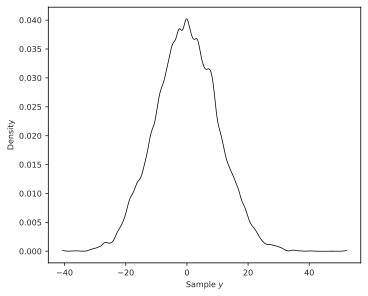

In [4]:
y_sim = stats.norm.rvs(loc=mu_prior, scale=sigma_prior, size=int(1e4))

bw = utils.bw_nrd0(y_sim)
az.plot_kde(y_sim, bw=bw*0.5)
plt.xlabel(r"Sample $y$")
plt.ylabel("Density");

Note that the prior distribution of `y` is centered on zero. If that strikes you as odd, remember that a continuous variable like `y` can always be re-centered to any value you like, without changing
any of the information in the data.

##### 4M2
Translate the model just above into a `PyMC` formula.

In [5]:
with pm.Model() as m_4m2:
    mu = pm.Normal('mu', 0, 10)
    sigma = pm.Exponential('sigma', 1)
    y = pm.Normal('y', mu=mu, sigma=sigma)

##### 4M3
Translate the quap model formula below into a mathematical model definition.

```R
y ~ dnorm( mu , sigma ),
mu <- a + b*x,
a ~ dnorm( 0 , 10 ),
b ~ dunif( 0 , 1 ),
sigma ~ dexp( 1 )
```

$$\begin{align*}
y_{i} &\sim \text{Normal}(\mu, \sigma)\\
\mu_{i} &= \alpha + \beta x_i\\
\alpha &\sim \text{Normal}(0,10)\\
\beta &\sim \text{Normal}(0,1)\\
\sigma &\sim \text{Exponential}(2)\\
\end{align*}$$

##### 4M4
A sample of students is measured for height each year for 3 years. After the third year, you want to fit a linear regression predicting height using year as a predictor. Write down the mathematical model definition for this regression, using any variable names and priors you choose. Be prepared to defend your choice of priors.

$$\begin{align*}
h_{i} &\sim \text{Normal}(\mu, \sigma)\\
\mu_{i} &= \alpha + \beta y_i\\
\alpha &\sim \text{Normal}(0,100)\\
\beta &\sim \text{Log-Normal}(0,1)\\
\sigma &\sim \text{Uniform}(0,50)\\
\end{align*}$$

Where $h$ is height and $y$ is year. These priors aren’t great, but they’ll do. The prior on the intercept $α$ is effectively uninformative. The problem didn’t say what scale height is measured on, so it’s hard to do much else here. The prior on $β$ is very weakly informative, centered on zero, which corresponds to no impact of year. This doesn’t seem like a great prior, because surely height increases each year or stays the same. So maybe a uniform prior above zero would be better?

- $\mu = \alpha + \beta y$ <- Assume the mean has some linear dependence on time.

- $\beta \sim \text{Log-Normal}(0,1)$ <- It seems perfectly sensible that the amount an average student's height changes per year should only be positive. Additionally, I have no idea what the growth rate is so this encodes ignorance about the rate of change of height per year.

There are other options, including **truncated distributions** or **log-Normal distributions**, but this hasn’t been introduced yet.

##### 4M5
Now suppose I remind you that every student got taller each year. Does this information lead you to change your choice of priors? How?

This one is subtle. On the one hand, having information on measurement scale lets us set a more sensible prior for the intercept, $α$. You might center it on 120 now, for example. On the other hand, for the prior to really be “prior,” it needs to be ignorance of the actual data values. Since the observed mean is a feature of the sample, not of the measurement scale, basing the prior on it could get you into trouble. What kind of trouble? It could lead to an illusionary fit to data, as essentially you’ve used the data twice: once in setting the prior and once in conditioning on the data (computing the posterior).

Much later, we’ll see how constraints on the data can be used to design models, without running the risk of using the data twice.

##### 4M6
Now suppose I tell you that the variance among heights for students of the same age is never more than 64cm. How does this lead you to revise your priors?

Again, this is a subtle issue. All the advice from just above applies. But it’s not clear here whether “variance among heights for students of the same age is never more than 64cm” is a feature of the sample or of the population. If it’s of the population, then setting a prior for it may be okay. In that case:

$$\sigma \sim \text{Uniform}(0,64)$$

would make sense.

##### 4M7
Refit model `m4_3` from the notebook, but omit the mean weight `xbar` this time. Compare the new model’s posterior to that of the original model. In particular, look at the covariance among the parameters. What is different? Then compare the posterior predictions of both models.

In [6]:
d = pd.read_csv("data/Howell1.csv", sep=';')
d2 = d[d['age'] >= 18]

In [7]:
xbar = d2.weight.mean()

with pm.Model() as m4_3:
    weight = pm.ConstantData("w", d2.weight.values, dims="obs_id")
    a = pm.Normal("a", mu=178, sigma=20)
    b = pm.LogNormal("b", mu=0, sigma=1)
    sigma = pm.Uniform("sigma", 0, 50)
    mu = pm.Deterministic('mu', a + b * (weight - xbar), dims="obs_id")
    height = pm.Normal("height", mu=mu, sigma=sigma, observed=d2.height.values, dims="obs_id")
    custom_step_m4_3 = utils.QuadraticApproximation([a, b, sigma], m4_3)
    trace_quap = pm.sample(draws=10_000, chains=1, tune=0, step=custom_step_m4_3, progressbar=False)  

Sequential sampling (1 chains in 1 job)
QuadraticApproximation: [a, b, sigma]
Sampling 1 chain for 0 tune and 10_000 draw iterations (0 + 10_000 draws total) took 3 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [8]:
az.summary(trace_quap, var_names=['~mu'], kind='stats', hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%
a,154.600,0.272,154.162,155.033
b,0.903,0.042,0.838,0.972
sigma,5.075,0.190,4.776,5.378


In [9]:
trace_quap_df = trace_quap.posterior.to_dataframe()
trace_quap_df.cov().round(3)

,a,b,sigma,mu
a,0.074,0.000,0.001,0.074
b,0.000,0.002,-0.000,0.000
sigma,0.001,-0.000,0.036,0.001
mu,0.074,0.000,0.001,34.043


Sampling: [height]


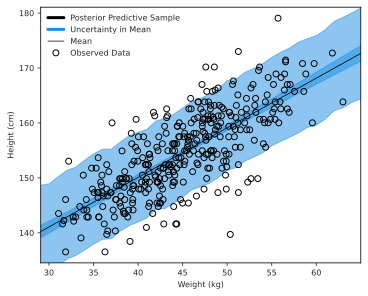

In [10]:
weight_seq = np.arange(25, 71)

with m4_3:  
    pm.set_data({"w": weight_seq})
    pred = pm.sample_posterior_predictive(
        trace_quap,
        var_names=["height", "mu"],
        return_inferencedata=True,
        predictions=True,
        extend_inferencedata=False,
        progressbar=False
    )

fig, ax = plt.subplots()

hdi_1 = az.plot_hdi(weight_seq, pred.predictions["height"], 
                     hdi_prob=0.89, smooth=False)  

hdi_2 = az.plot_hdi(weight_seq, pred.predictions["mu"], 
                     hdi_prob=0.89, smooth=False) 

mean_line, = ax.plot(weight_seq, pred.predictions["mu"].mean(axis=1)[0], 'k', label='Mean')
obs_data, = ax.plot(d2.weight, d2.height, 'o', fillstyle='none', label='Observed Data', color='k')

hdi_patch1 = plt.Line2D([0], [1], color='C0', lw=3, label="Posterior Predictive Sample")
hdi_patch2 = plt.Line2D([0], [1], color='C1', lw=3, label="Uncertainty in Mean")

ax.set(xlabel="Weight (kg)",
       ylabel="Height (cm)",
       xlim=(d2.weight.min() - 2, d2.weight.max() + 2),
       ylim=(d2.height.min() - 2, d2.height.max() + 2))

ax.legend(handles=[hdi_patch1, hdi_patch2, mean_line, obs_data]);

In [11]:
with pm.Model() as m4_3_mod:
    weight = pm.ConstantData("w", d2.weight.values, dims="obs_id")
    a = pm.Normal("a", mu=178, sigma=20)
    b = pm.LogNormal("b", mu=0, sigma=1)
    sigma = pm.Uniform("sigma", 0, 50)
    mu = pm.Deterministic('mu', a + b * weight, dims="obs_id")
    height = pm.Normal("height", mu=mu, sigma=sigma, observed=d2.height.values, dims="obs_id")
    custom_step_m4_3 = utils.QuadraticApproximation([a, b, sigma], m4_3_mod)
    trace_quap_mod = pm.sample(draws=10_000, chains=1, tune=0, step=custom_step_m4_3, progressbar=False)  

Sequential sampling (1 chains in 1 job)
QuadraticApproximation: [a, b, sigma]
Sampling 1 chain for 0 tune and 10_000 draw iterations (0 + 10_000 draws total) took 4 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [12]:
az.summary(trace_quap_mod, var_names=['~mu'], kind='stats', hdi_prob=0.89)


,mean,sd,hdi_5.5%,hdi_94.5%
a,114.511,1.899,111.529,117.586
b,0.891,0.042,0.824,0.958
sigma,5.072,0.193,4.766,5.380


In [13]:
trace_quap_mod_df = trace_quap_mod.posterior.to_dataframe()
trace_quap_mod_df.cov().round(3)

,a,b,sigma,mu
a,3.607,-0.079,0.010,0.073
b,-0.079,0.002,-0.000,0.000
sigma,0.010,-0.000,0.037,-0.001
mu,0.073,0.000,-0.001,33.157


Sampling: [height]


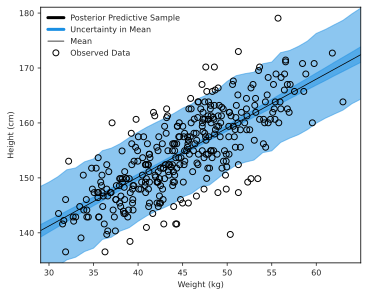

In [14]:
weight_seq = np.arange(25, 71)

with m4_3_mod:  
    pm.set_data({"w": weight_seq})
    pred = pm.sample_posterior_predictive(
        trace_quap_mod,
        var_names=["height", "mu"],
        return_inferencedata=True,
        predictions=True,
        extend_inferencedata=False,
        progressbar=False
    )

fig, ax = plt.subplots()

hdi_1 = az.plot_hdi(weight_seq, pred.predictions["height"], 
                     hdi_prob=0.89, smooth=False)  

hdi_2 = az.plot_hdi(weight_seq, pred.predictions["mu"], 
                     hdi_prob=0.89, smooth=False) 

mean_line, = ax.plot(weight_seq, pred.predictions["mu"].mean(axis=1)[0], 'k', label='Mean')
obs_data, = ax.plot(d2.weight, d2.height, 'o', fillstyle='none', label='Observed Data', color='k')

hdi_patch1 = plt.Line2D([0], [1], color='C0', lw=3, label="Posterior Predictive Sample")
hdi_patch2 = plt.Line2D([0], [1], color='C1', lw=3, label="Uncertainty in Mean")

ax.set(xlabel="Weight (kg)",
       ylabel="Height (cm)",
       xlim=(d2.weight.min() - 2, d2.weight.max() + 2),
       ylim=(d2.height.min() - 2, d2.height.max() + 2))

ax.legend(handles=[hdi_patch1, hdi_patch2, mean_line, obs_data]);

It can be seen that the posterior values of both models look rather similar to each other. However the in the variance-covariance matrix appear to be a couple of orders of magnitude larger when one doesn't subtract the mean values from the data. Why is this? It's because the parameters signify different things in the two different models.

Inspect the model again:

Originally we had

$\mu_i = \alpha + \beta(x_i - \bar{x})$

and in the second run we are instead deciding to fit

$\mu_i = \alpha' + \beta x_i$

We can see that doing this in no way changes the model that is being fit to the data as we can derive one from the other as follows

$\mu_i = \alpha + \beta(x_i - \bar{x}) = \alpha - \beta \bar{x} + \beta x_i = \alpha' + \beta x_i$

That is to say

$ \alpha' = \alpha - \beta \bar{x}$

So as we can see, we can literally derive one parameter from the other. So why is the variance and covariance for the posterior of $\alpha'$ so much larger than for $\alpha$? It's because of what these parameters represent. For $\alpha$, it can be seen that $\mu = \alpha$ when $x = \bar{x}$. That is $\alpha$ represents the mean height at the mean weight. Therefore, the uncertainty in $\alpha$ is equivalent to the uncertainty in $\mu$ when $x = \bar{x}$, the mean of the weight. On the other hand, $\mu = \alpha'$ when $x = 0$, that is $\alpha$ represent the y-intercept of the data.

##### 4M8
In the chapter, we used 15 knots with the cherry blossom spline. Increase the number of knots and observe what happens to the resulting spline. Then adjust also the width of the prior on the weights—change the standard deviation of the prior and watch what happens. What do you think the combination of knot number and the prior on the weights controls?

In [15]:
from patsy import dmatrix

def bspline_regression_plots(data, knot_list, degree, w_std_prior=10):
    
    B_mat = np.asarray(dmatrix(
        f"bs(year, knots=knots, degree={degree}, include_intercept=True)-1",
        {"year": data.year.values, "knots": knot_list[1:-1]},
    ))    
    
    with pm.Model() as model:
        B = pm.ConstantData("B", B_mat)
        a = pm.Normal("a", mu=100, sigma=10)
        w = pm.Normal("w", mu=0, sigma=w_std_prior, shape=B.shape[1])
        sigma = pm.Exponential("sigma", 1)
        mu = pm.Deterministic('mu', a + pm.math.dot(B, w.T))
        D = pm.Normal("D", mu=mu, sigma=sigma, observed=data.doy.values)    
        custom_steps = utils.QuadraticApproximation([a, w, sigma], model)
        trace_quap = pm.sample(draws=1_000, chains=1, tune=0, step=custom_steps, progressbar=False)  
    
    wp = trace_quap.posterior.w.mean(dim=["chain", "draw"]).to_numpy()
    
    _, axs = plt.subplots(3, 1, figsize=(8, 8))
    axs[0].plot(data.year, B_mat)
    axs[0].set(xlabel='Year', ylabel='Basis Value')
    
    axs[1].plot(data.year, B_mat * wp)
    axs[1].set(xlabel='Year', ylabel='Basis * Weight')    
    
    az.plot_hdi(d2.year, trace_quap.posterior['mu'], smooth=False, color='k', ax=axs[2])
    axs[2].plot(d2.year, d2.doy, 'o', color='pink', alpha=0.6)
    axs[2].set(xlabel='Year', ylabel='Day in Year')

Sequential sampling (1 chains in 1 job)
QuadraticApproximation: [a, w, sigma]
Sampling 1 chain for 0 tune and 1_000 draw iterations (0 + 1_000 draws total) took 3 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


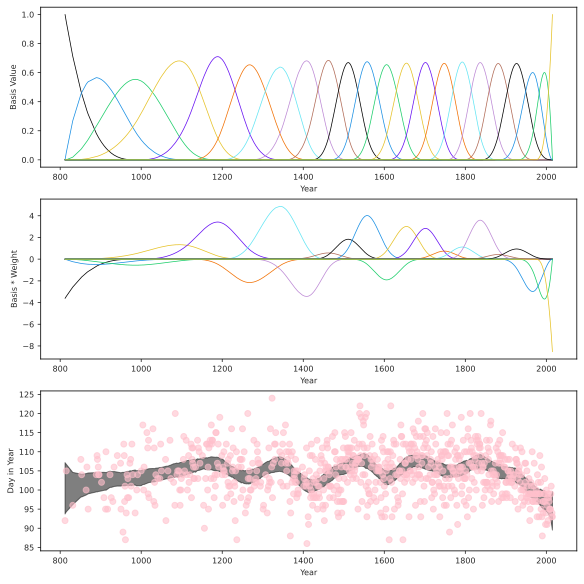

In [16]:
d = pd.read_csv("data/cherry_blossoms.csv", sep=';')
d2 = d[d[['doy']].notna().all(axis=1)]

num_knots = 20
knot_list = np.quantile(d2.year, np.linspace(0, 1, num_knots))


bspline_regression_plots(d2, knot_list, degree=3, w_std_prior=20)

Sequential sampling (1 chains in 1 job)
QuadraticApproximation: [a, w, sigma]
Sampling 1 chain for 0 tune and 1_000 draw iterations (0 + 1_000 draws total) took 7 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


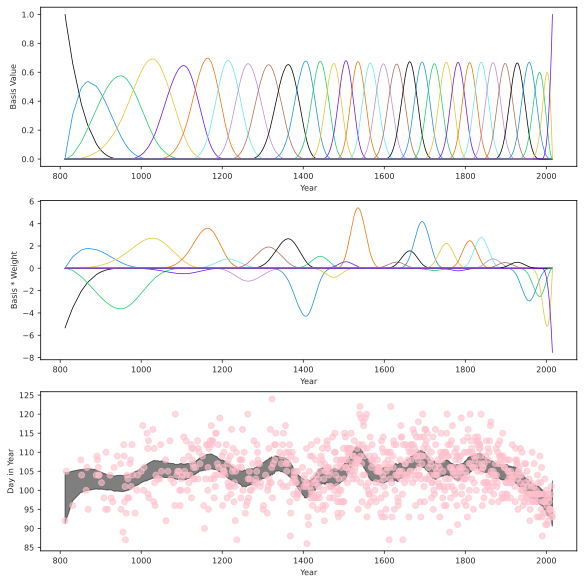

In [17]:
num_knots = 30
knot_list = np.quantile(d2.year, np.linspace(0, 1, num_knots))


bspline_regression_plots(d2, knot_list, degree=3, w_std_prior=10)

Sequential sampling (1 chains in 1 job)
QuadraticApproximation: [a, w, sigma]
Sampling 1 chain for 0 tune and 1_000 draw iterations (0 + 1_000 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


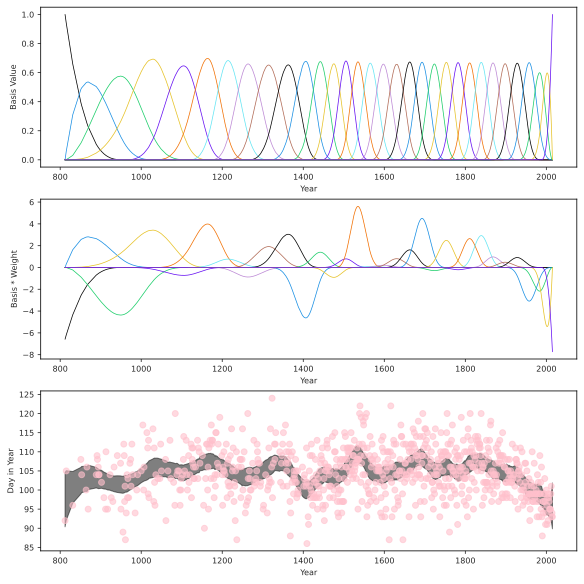

In [18]:
num_knots = 30
knot_list = np.quantile(d2.year, np.linspace(0, 1, num_knots))


bspline_regression_plots(d2, knot_list, degree=3, w_std_prior=30)

Increasing the number of knots increases the 'wiggles' and the increasing the standard deviation of the weight increases the width/thickness of $\mu$'s HDI plot.

##### 4H1
The weights listed below were recorded in the !Kung census, but heights were not recorded for these individuals. Provide predicted heights and 89% intervals for each of these individuals. That is, fill in the table below, using model-based predictions.

| Individual | Weight | Expected Height | 89% Interval |  
|------------|--------|-----------------|--------------|
| 1          | 46.95  |                 |              |
| 2          | 43.72  |                 |              |
| 3          | 64.78  |                 |              |
| 4          | 32.59  |                 |              |
| 5          | 54.63  |                 |              |

Method 1: PyMC's sample posterior predictive function

In [19]:
missing_data = pd.DataFrame({'individual': np.arange(5)+1,
                             'weight': np.array([46.95, 43.72, 64.78, 32.59, 54.63])})

d = pd.read_csv("data/Howell1.csv", sep=';')
d2 = d[d['age'] >= 18]

xbar = d2.weight.mean()

with pm.Model() as m4_3:
    weight = pm.ConstantData("w", d2.weight.values, dims="obs_id")
    a = pm.Normal("a", mu=178, sigma=20)
    b = pm.LogNormal("b", mu=0, sigma=1)
    sigma = pm.Uniform("sigma", 0, 50)
    mu = pm.Deterministic('mu', a + b * (weight - xbar), dims="obs_id")
    height = pm.Normal("height", mu=mu, sigma=sigma, observed=d2.height.values, dims="obs_id")
    
    # mean_q = pm.find_MAP()
    # Hess = pm.find_hessian(mean_q, vars=[a, b, sigma])
    
    custom_step_m4_3 = utils.QuadraticApproximation([a, b, sigma], m4_3)
    trace_quap = pm.sample(draws=10_000, chains=1, tune=0, step=custom_step_m4_3, progressbar=False) 
     
    pm.set_data({"w": missing_data.weight})
    pred = pm.sample_posterior_predictive(
        trace_quap,
        var_names=["height", "mu"],
        return_inferencedata=True,
        predictions=True,
        extend_inferencedata=False,
        progressbar=False
    )

Sequential sampling (1 chains in 1 job)
QuadraticApproximation: [a, b, sigma]
Sampling 1 chain for 0 tune and 10_000 draw iterations (0 + 10_000 draws total) took 7 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Sampling: [height]


In [20]:
missing_data['expected_height'] = pred.predictions.mu.mean(axis=1)[0]
hdi_vals = az.hdi(pred.predictions.height, hdi_prob=0.89).height
missing_data['hdi_5.5'] = hdi_vals[:,0]
missing_data['hdi_94.5'] = hdi_vals[:,1]

missing_data.round(2)

,individual,weight,expected_height,hdi_5.5,hdi_94.5
0,1,46.95,156.37,147.71,164.09
1,2,43.72,153.46,145.20,161.43
2,3,64.78,172.48,164.06,180.39
3,4,32.59,143.40,135.10,151.37
4,5,54.63,163.31,154.97,171.47


##### 4H2
Select out all the rows in the Howell1 data with ages below 18 years of age. If you do it right, you should end up with a new data frame with 192 rows in it.

1) Fit a linear regression to these data, using `PyMC`. Present and interpret the estimates. For every 10 units of increase in weight, how much taller does the model predict a child gets?
2) Plot the raw data, with height on the vertical axis and weight on the horizontal axis. Super-impose the MAP regression line and 89% interval for the mean. Also superimpose the 89% interval for predicted heights.
3) What aspects of the model fit concern you? Describe the kinds of assumptions you would change, if any, to improve the model. You don’t have to write any new code. Just explain what the model appears to be doing a bad job of, and what you hypothesize would be a better model.

In [21]:
d = pd.read_csv("data/Howell1.csv", sep=';')
d2 = d[d['age'] < 18]

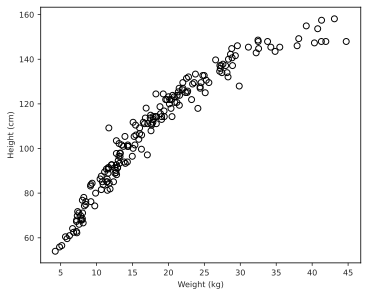

In [22]:
plt.plot(d2.weight, d2.height, 'o', fillstyle='none')
plt.ylabel("Height (cm)")
plt.xlabel("Weight (kg)");

1) Fit a linear regression to these data, using `PyMC`. Present and interpret the estimates. For every 10 units of increase in weight, how much taller does the model predict a child gets?

In [23]:
weight_seq = np.linspace(1, 45, 50)

with pm.Model() as m4:
    weight = pm.ConstantData("w", d2.weight.values, dims="obs_id")
    a = pm.Normal("a", mu=100, sigma=100)
    b = pm.Normal("b", mu=0, sigma=10)
    sigma = pm.Uniform("sigma", 0, 50)
    mu = pm.Deterministic('mu', a + b * weight, dims="obs_id")
    height = pm.Normal("height", mu=mu, sigma=sigma, observed=d2.height.values, dims="obs_id")
    
    custom_step_m4 = utils.QuadraticApproximation([a, b, sigma], m4)
    trace_quap = pm.sample(draws=10_000, chains=1, tune=0, step=custom_step_m4, progressbar=False)
    
    pm.set_data({"w": weight_seq})
    pred = pm.sample_posterior_predictive(
        trace_quap,
        var_names=["height", "mu"],
        return_inferencedata=True,
        predictions=True,
        extend_inferencedata=False,
        progressbar=False
    )

Sequential sampling (1 chains in 1 job)
QuadraticApproximation: [a, b, sigma]
Sampling 1 chain for 0 tune and 10_000 draw iterations (0 + 10_000 draws total) took 3 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Sampling: [height]


In [24]:
az.summary(trace_quap, var_names=['~mu'], kind='stats', hdi_prob=0.89).round(2)

,mean,sd,hdi_5.5%,hdi_94.5%
a,58.24,1.38,56.08,60.51
b,2.72,0.07,2.61,2.83
sigma,8.44,0.42,7.74,9.09


The estimates suggest that the MAP coefficient for weight is 2.7. This implies that for a unit change of 1kg of weight, we predict an average of 2.7cm of increase in height.

2) Plot the raw data, with height on the vertical axis and weight on the horizontal axis. Super-impose the MAP regression line and 89% interval for the mean. Also superimpose the 89% interval for predicted heights.

We will sample from the posterior predictive, then compute 90% intervals for the mean and predicted heights.

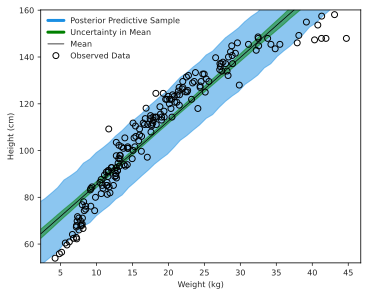

In [25]:
fig, ax = plt.subplots()

hdi_1 = az.plot_hdi(weight_seq, pred.predictions.height, 
                     hdi_prob=0.89, smooth=False, color='C1')  

hdi_2 = az.plot_hdi(weight_seq, pred.predictions.mu, 
                     hdi_prob=0.89, smooth=False, color='green') 

mean_line, = ax.plot(weight_seq, pred.predictions.mu.mean(axis=1)[0], 'k', label='Mean')
obs_data, = ax.plot(d2.weight, d2.height, 'o', fillstyle='none', label='Observed Data', color='k')

hdi_patch1 = plt.Line2D([0], [1], color='C1', lw=3, label="Posterior Predictive Sample")
hdi_patch2 = plt.Line2D([0], [1], color='green', lw=3, label="Uncertainty in Mean")

ax.set(xlabel="Weight (kg)",
       ylabel="Height (cm)",
       xlim=(d2.weight.min() - 2, d2.weight.max() + 2),
       ylim=(d2.height.min() - 2, d2.height.max() + 2))

ax.legend(handles=[hdi_patch1, hdi_patch2, mean_line, obs_data]);

3) What aspects of the model fit concern you? Describe the kinds of assumptions you would change, if any, to improve the model. You don’t have to write any new code. Just explain what the model appears to be doing a bad job of, and what you hypothesize would be a better model.

The major problem with this model appears to be that the relationship between weight and height, for non-adults, isn’t very linear. Instead it is curved. As a result, at low weight values, the predicted mean is above most of the actual heights. At middle weight values, the predicted mean is below most of the heights. Then again at high weight values, the mean is above the heights.

A parabolic model would likely fit these data much better. But that’s not the only option. What we’re after essentially is some way to model a reduction of the slope between height and weight, as weight increases.

##### 4H3
Suppose a colleague of yours, who works on allometry, glances at the practice problems just above. Your colleague exclaims, “That’s silly. Everyone knows that it’s only the logarithm of body weight that scales with height!” Let’s take your colleague’s advice and see what happens. 

1) Model the relationship between height (cm) and the natural logarithm of weight (log-kg). Use the entire Howell1 data frame, all 544 rows, adults and non-adults. Can you interpret the resulting estimates?
2) Begin with this plot. Then use samples from the quadratic approximate posterior of the model in (a) to superimpose on the plot: (1) the predicted mean height as a function of weight, (2) the 97% interval for the mean, and (3) the 97% interval for predicted heights.

1) Model the relationship between height (cm) and the natural logarithm of weight (log-kg). Use the entire Howell1 data frame, all 544 rows, adults and non-adults. Can you interpret the resulting estimates?

In [26]:
d = pd.read_csv("data/Howell1.csv", sep=';')
d['log_weight'] = np.log(d['weight'])

In [27]:
log_weight_seq = np.linspace(1.4, 4.2, 50)

with pm.Model() as m4:
    weight = pm.ConstantData("w", d.log_weight, dims="obs_id")
    a = pm.Normal("a", mu=100, sigma=100)
    b = pm.Normal("b", mu=0, sigma=10)
    sigma = pm.Uniform("sigma", 0, 50)
    mu = pm.Deterministic('mu', a + b * weight, dims="obs_id")
    height = pm.Normal("height", mu=mu, sigma=sigma, observed=d.height.values, dims="obs_id")
    
    custom_step_m4 = utils.QuadraticApproximation([a, b, sigma], m4)
    trace_quap = pm.sample(draws=10_000, chains=1, tune=0, step=custom_step_m4, progressbar=False)
    
    pm.set_data({"w": log_weight_seq})
    pred = pm.sample_posterior_predictive(
        trace_quap,
        var_names=["height", "mu"],
        return_inferencedata=True,
        predictions=True,
        extend_inferencedata=False,
        progressbar=False
    )

Sequential sampling (1 chains in 1 job)
QuadraticApproximation: [a, b, sigma]
Sampling 1 chain for 0 tune and 10_000 draw iterations (0 + 10_000 draws total) took 4 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Sampling: [height]


In [28]:
az.summary(trace_quap, var_names=['~mu'], kind='stats', hdi_prob=0.89).round(2)

,mean,sd,hdi_5.5%,hdi_94.5%
a,-23.56,1.33,-25.70,-21.47
b,47.01,0.38,46.41,47.62
sigma,5.14,0.16,4.88,5.38


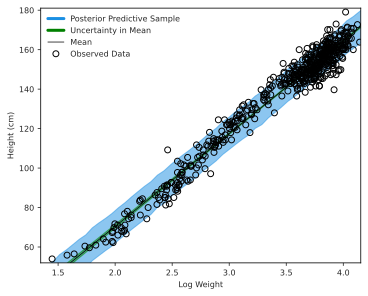

In [29]:
fig, ax = plt.subplots()

hdi_1 = az.plot_hdi(log_weight_seq, pred.predictions.height, 
                     hdi_prob=0.89, smooth=False, color='C1')  

hdi_2 = az.plot_hdi(log_weight_seq, pred.predictions.mu, 
                     hdi_prob=0.89, smooth=False, color='green') 

mean_line, = ax.plot(log_weight_seq, pred.predictions.mu.mean(axis=1)[0], 'k', label='Mean')
obs_data, = ax.plot(d.log_weight, d.height, 'o', fillstyle='none', label='Observed Data', color='k')

hdi_patch1 = plt.Line2D([0], [1], color='C1', lw=3, label="Posterior Predictive Sample")
hdi_patch2 = plt.Line2D([0], [1], color='green', lw=3, label="Uncertainty in Mean")

ax.set(xlabel="Log Weight",
       ylabel="Height (cm)",
       xlim=(d.log_weight.min()-0.1, d.log_weight.max()+0.01),
       ylim=(d.height.min()-2, d.height.max()+2))

ax.legend(handles=[hdi_patch1, hdi_patch2, mean_line, obs_data]);

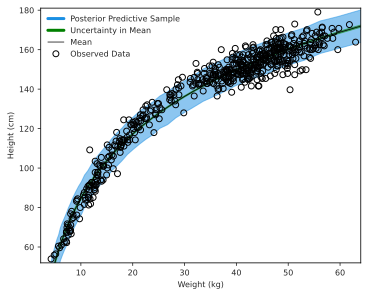

In [30]:
weight_seq = np.exp(log_weight_seq)

fig, ax = plt.subplots()

hdi_1 = az.plot_hdi(weight_seq, pred.predictions.height, 
                     hdi_prob=0.89, smooth=False, color='C1')  

hdi_2 = az.plot_hdi(weight_seq, pred.predictions.mu, 
                     hdi_prob=0.89, smooth=False, color='green') 

mean_line, = ax.plot(weight_seq, pred.predictions.mu.mean(axis=1)[0], 'k', label='Mean')
obs_data, = ax.plot(d.weight, d.height, 'o', fillstyle='none', label='Observed Data', color='k')

hdi_patch1 = plt.Line2D([0], [1], color='C1', lw=3, label="Posterior Predictive Sample")
hdi_patch2 = plt.Line2D([0], [1], color='green', lw=3, label="Uncertainty in Mean")

ax.set(xlabel="Weight (kg)",
       ylabel="Height (cm)",
       xlim=(d.weight.min() - 2, d.weight.max() + 1),
       ylim=(d.height.min() - 2, d.height.max() + 2))

ax.legend(handles=[hdi_patch1, hdi_patch2, mean_line, obs_data]);

The model may have been linear, but plotted on the raw scale of measurement, it is clearly non-linear. Not only is the trend for the mean curved, but the variance around the mean is not constant, on this scale. Instead, the variance around the mean increases with weight. On the scale you fit the model on, the variance was assumed to be constant. But once you transform the measurement scale, it usually won’t be.

Notice also that the estimate for the mean is so precise that you can hardly even see the confidence interval for it. Don’t get too confident about such results, though. Remember, all inferences of the model are conditional on the model. Even estimated trends that do a terrible job of prediction can have tight confidence intervals, when the data set is large.

##### 4H4
Plot the prior predictive distribution for the parabolic polynomial regression model in the notebook. You can modify the code that plots the linear regression prior predictive distribution. Can you modify the prior distributions of $α$, $β_1$, and $β_2$ so that the prior predictions stay within the biologically reasonable outcome space? That is to say: Do not try to fit the data by hand. But do try to keep the curves consistent with what you know about height and weight, before seeing these exact data.

In [31]:
d = pd.read_csv("data/Howell1.csv", sep=';')
d['weight_s'] = (d.weight.values - d.weight.mean())/d.weight.std()
d['weight_s2'] = d.weight_s**2

In [32]:
with pm.Model() as m4_poly:
    weight = pm.ConstantData("w", d.weight_s, dims="obs_id")
    weight_s = pm.ConstantData("w_s", d.weight_s2, dims="obs_id")
    a = pm.Normal("a", mu=178, sigma=20)
    b1 = pm.LogNormal("b1", mu=0, sigma=1)
    b2 = pm.Normal('b2', mu=0, sigma=1)
    sigma = pm.Uniform("sigma", 0, 50)
    mu = pm.Deterministic('mu', a + b1 * weight + b2 * weight_s, dims="obs_id")
    height = pm.Normal("height", mu=mu, sigma=sigma, observed=d.height.values, dims="obs_id")
    pp = pm.sample_prior_predictive(samples=10_000)

Sampling: [a, b1, b2, height, sigma]


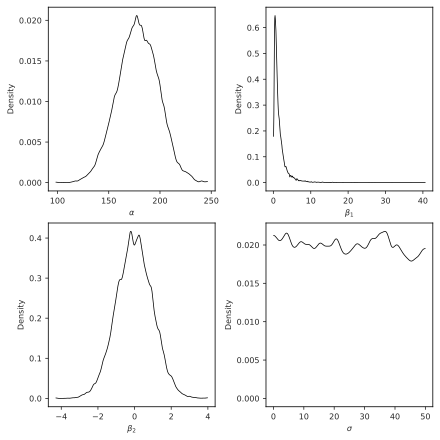

In [33]:
a_dens = np.random.normal(178, 20, size=int(1e4))
b1_dens = np.random.lognormal(0, 1, size=int(1e4))
b2_dens = np.random.normal(0, 1, size=int(1e4))
sigma_dens = np.random.uniform(0, 50, size=int(1e4))

dens_list = [a_dens, b1_dens, b2_dens, sigma_dens]
labels = [r'$\alpha$', r'$\beta_1$', r'$\beta_2$', r'$\sigma$']

_ , axs = plt.subplots(2, 2, figsize=(6,6))

for i, (dens, ax) in enumerate(zip(dens_list, axs.flatten())):
    bw = utils.bw_nrd0(dens)
    az.plot_kde(dens, bw=bw*0.5, ax=ax)
    ax.set(xlabel=labels[i], ylabel='Density')

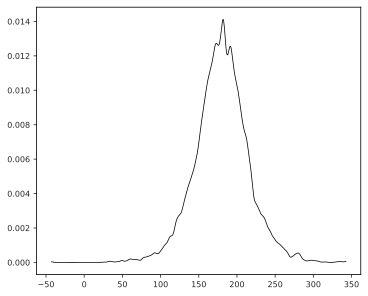

In [34]:
rand_index = np.random.choice(len(d))
mu_dens = a_dens + b1_dens * d.weight_s[rand_index] + b2_dens * d.weight_s2[rand_index]
prior_h = np.random.normal(loc=mu_dens, scale=sigma_dens)

bw = utils.bw_nrd0(prior_h)
az.plot_kde(prior_h, bw=bw*0.5);

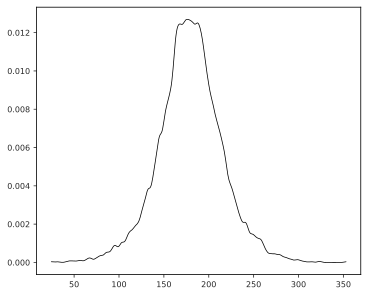

In [35]:
prior_h = pp.prior_predictive.height[0][:,rand_index].to_numpy()
bw = utils.bw_nrd0(prior_h)
az.plot_kde(prior_h, bw=bw*0.5);

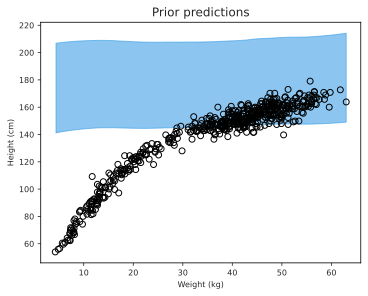

In [36]:
x = np.linspace(0, 70)
weight_s = (x - d.weight.mean()) / d.weight.std()
means = pp.prior["a"] + np.outer(weight_s, pp.prior["b1"]) + np.outer(weight_s**2, pp.prior["b2"])

az.plot_hdi(d.weight, pp.prior.mu[0].to_numpy(), hdi_prob=0.89)
plt.plot(d.weight, d.height, 'o', fillstyle='none')
plt.ylabel("Height (cm)")
plt.xlabel("Weight (kg)")
plt.title("Prior predictions");

The justifications for the priors are written along side:

$H_i \sim N(\mu_i,\sigma)$

$\mu_i = \alpha + \beta_1 (x_i - \overline{x}) - \beta_2(x_i - \overline{x})^2 $ -> Note that it's $-\beta_2$. Positive prior on $\beta$ ensures the paraboloid curves in the correct direction.

$\alpha \sim N(150,30^2)$ -> Reduced mean height at mean weight, as we are looking at a much larger age range now, so we expect younger people to drag the mean height down at any given weight relative to the adult only data set

$\beta_1 \sim Lognormal(0,1)$ -> Need a linear base line to perturb with a quadratic term

The seconds term puts a small deviation from linearity

$\beta_2 \sim exp(0.05)$ -> This should be positive to ensure concavity, and small to ensure small only small perturbation from linearity in weights

$\sigma$ ~ $Unif(0,50)$

In [37]:
d = pd.read_csv("data/Howell1.csv", sep=';')
d['weight_s'] = d.weight - d.weight.mean()
d['weight_s2'] = d.weight_s**2

In [38]:
with pm.Model() as m4_poly:
    weight = pm.ConstantData("w", d.weight_s, dims="obs_id")
    weight_s = pm.ConstantData("w_s", d.weight_s2, dims="obs_id")
    a = pm.Normal("a", mu=150, sigma=30)
    b1 = pm.LogNormal("b1", mu=0, sigma=1)
    b2 = pm.Exponential('b2', 1 / 0.05)
    sigma = pm.Uniform("sigma", 0, 1)
    mu = pm.Deterministic('mu', a + b1 * weight - b2 * weight_s, dims="obs_id")
    height = pm.Normal("height", mu=mu, sigma=sigma, observed=d.height.values, dims="obs_id")
    pp = pm.sample_prior_predictive(samples=10_000)

Sampling: [a, b1, b2, height, sigma]


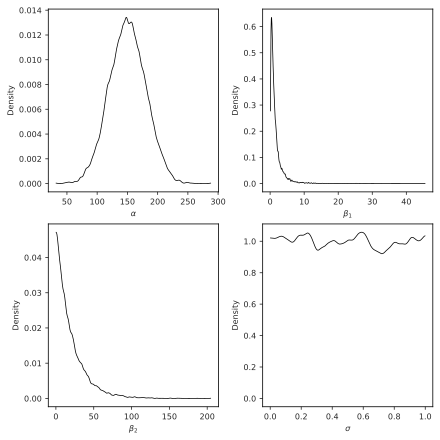

In [39]:
a_dens = np.random.normal(150, 30, size=int(1e4))
b1_dens = np.random.lognormal(0, 1, size=int(1e4))
b2_dens = np.random.exponential(1/0.05, size=int(1e4))
sigma_dens = np.random.uniform(0, 1, size=int(1e4))

dens_list = [a_dens, b1_dens, b2_dens, sigma_dens]
labels = [r'$\alpha$', r'$\beta_1$', r'$\beta_2$', r'$\sigma$']

_ , axs = plt.subplots(2, 2, figsize=(6,6))

for i, (dens, ax) in enumerate(zip(dens_list, axs.flatten())):
    bw = utils.bw_nrd0(dens)
    az.plot_kde(dens, bw=bw*0.5, ax=ax)
    ax.set(xlabel=labels[i], ylabel='Density')

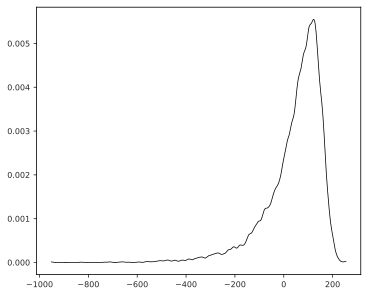

In [40]:
rand_index = np.random.choice(len(d))
mu_dens = a_dens + b1_dens * d.weight_s[rand_index] - b2_dens * d.weight_s2[rand_index]
prior_h = np.random.normal(loc=mu_dens, scale=sigma_dens)

bw = utils.bw_nrd0(prior_h)
az.plot_kde(prior_h, bw=bw*0.5);

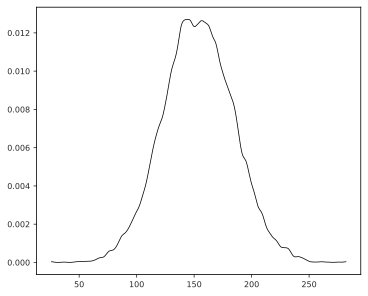

In [41]:
prior_h = pp.prior_predictive.height[0][:,rand_index].to_numpy()
bw = utils.bw_nrd0(prior_h)
az.plot_kde(prior_h, bw=bw*0.5);

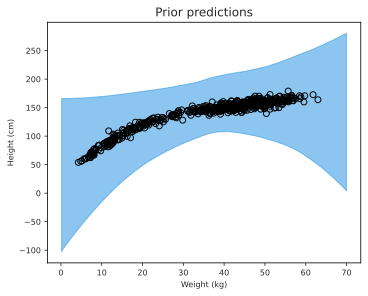

In [42]:
x = np.linspace(0, 70)
mh = x - np.mean(d.weight)
means = pp.prior["a"] + np.outer(mh, pp.prior["b1"]) - np.outer(mh ** 2, pp.prior["b2"])
az.plot_hdi(x, means.T, hdi_prob=0.89)
plt.plot(d.weight, d.height, 'o', fillstyle='none')
plt.ylabel("Height (cm)")
plt.xlabel("Weight (kg)")
plt.title("Prior predictions");

By using an exponential prior on $\beta_2$ this ensures the parabolic curve must be concave, thus no increasing growth in height with weight is possible and makes perfect sense on physical grounds. However, extreme and absurd values are still found near the extremes of the data. One could tighten the parameters to ensure this didn't happen, but as a first approximation this isn't too bad.

##### 4H5
Return to `cherry_blossoms` and model the association between blossom date (`doy`) and March temperature (`temp`). Note that there are many missing values in both variables. You may consider a linear model, a polynomial, or a spline on temperature. How well does temperature trend predict the blossom trend?